In [7]:
import pandas as pd
import numpy as np

import math
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys

try:
    from tqdm.notebook import tqdm
except Exception:
    print('For a nice progress bar install tqdm (pip3 install tqdm)', file=sys.stderr)
    def tqdm(iterable, *args, **kwargs):
        return iterable

    
def progress_wrapper(iterable, level, max_progress_level):
    if level == 0:
        return tqdm(iterable)
    elif level <= max_progress_level:  # configurable
        return tqdm(iterable, leave=False)
    else:
        return iterable
    

def compute_loss(time_points, predicted_metrics, true_metrics):
    loss_sum = 0.0
    # Iterace through infected, recovered and dead
    for predicted, true in zip(predicted_metrics, true_metrics):
        true = true.to_numpy().astype('float64')
        assert predicted.shape[0] == true.shape[0], "expected solution's size to be {}, but got {}".format(true.shape[0], predicted.shape[0])
#         max_values = np.stack([true, predicted, np.full_like(true, 0.0001)], axis=1).max(axis=1)
        loss_sum += np.mean((true - predicted) ** 2)
    return loss_sum


def cut_metrics(metrics, from_idx, to_idx):
    if to_idx is None:
        return [x[from_idx:] for x in metrics]
    else:
        return [x[from_idx:to_idx] for x in metrics]


def fit(ode_system_getter, time_points, params, to_metrics, true_metrics, max_progress_level=1, val_samples=0):
    """
    ode_system_getter: функция, которая получает набор параметров из params и возвращает tuple,
                       в котором первый элемент – функция, задающая систему уравнений
                       (и принимающая только параметры y и t)
                       и соответствующая аргументу func функции scipy.integrate.odeint,
                       а второй элемент – вектор начальных условий y0 функции scipy.integrate.odeint
    time_points: точки, для которых нужно решить систему уранений. Аналогично параметру t в scipy.integrate.odeint
    params: список, в котором каждый i-тый элемент –
            список возможных значений i-того параметра, передаваемого в ode_system_getter
    to_metrics: функция, принимающая solution (результат функции scipy.integrate.odeint)
                и отдающая список метрик, по которым будет производиться оценка параметров.
                каждая метрика – одномерный numpy-массив значений
    true_metrics: список метрик для данных, под которые мы подстраиваемся
                  каждая метрика – одномерный numpy-массив значений
    max_progress_level: глубина вложенных циклов, для которых будет отображаться progress-bar. Считается от 0.
    val_samples: количество элементов, отсекаемых на валидацию.
                 целое число означает количество элементов,
                 дробное в интервале (0;1) – долю от общего числа элементов
                  
    
    """
    
    val_len = math.ceil(len(time_points)*val_samples) if val_samples < 1 else val_samples
    train_len = len(time_points) - val_len
    assert train_len > 0, 'Too big value for val_samples, no train samples left'
    if val_len <= 0:
        print('Too small value for val_samples, no validation loss will be computed', file=sys.stderr)
    train_points = time_points[:train_len]
    val_points = time_points[train_len:]
    true_train = cut_metrics(true_metrics, 0, train_len)
    true_val = cut_metrics(true_metrics, train_len, None)
    
    def fit_stage(left_params, current_values, level):
        if left_params:
            best_train_loss = None
            best_val_loss = None
            best_solution = None
            best_params = None
            for param_value in progress_wrapper(left_params[-1], level, max_progress_level):
                new_values = current_values + (param_value,)
                return_value = fit_stage(left_params[:-1], new_values, level+1)
                if return_value is None:
                    continue
                train_loss, val_loss, solution, params_for_loss = return_value
                if best_train_loss is None or best_train_loss > train_loss:
                    best_train_loss = train_loss
                    best_val_loss = val_loss
                    best_solution = solution
                    best_params = params_for_loss
            return best_train_loss, best_val_loss, best_solution, best_params
        else:
            return_value = ode_system_getter(*list(reversed(current_values)))
            if return_value is None:  # e.g. invalid parameters
                return None
            ode_system, initial_conditions = return_value
            solution = odeint(ode_system, initial_conditions, time_points)
            train_loss = compute_loss(train_points, cut_metrics(to_metrics(solution), 0, train_len), true_train)
            if val_len > 0:
                val_loss = compute_loss(val_points, cut_metrics(to_metrics(solution), train_len, None), true_val)
            else:
                val_loss = 0.0
            return train_loss, val_loss, solution, current_values
    
    best_train_loss, val_loss, best_solution, best_params = fit_stage(params, tuple(), 0)
    return best_train_loss, val_loss, best_solution, tuple(reversed(best_params))


# Небольшая функция для быстрой отрисовки графичков, объединяющая реальные данные и смоделированные
def plot_data_together(time_points, predicted_data, true_data, upper_limit, labels=None, log_lower_bound=1e-3):
    colors = ['b', 'g', 'r', 'y', 'k', 'm']
    if not labels:
        labels = ['']*len(true_data)
    
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
        plt.plot(time_points, y_pred, color, label=label+' (pred)')
        
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([0, upper_limit])

    #Same plot but on log scale
    plt.subplot(1,2,2)
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
        plt.plot(time_points, y_pred, color, label=label+' (pred)')
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([log_lower_bound, upper_limit])

# SEIR Absolute

In [10]:
import math

POPULATION = 46754627
N=POPULATION

params = [
    np.logspace(0, 3.5, 10),
    np.logspace(0, 3.5, 10),
    np.logspace(-4, -1, 10),
    [0.6],
    np.logspace(-3, -1, 10),
    np.linspace(0.1, 0.99, 10)
]
def func_getter(beta_q, beta_a, delta, mortality, gamma, asymptomatic):
    # Если набор параметров невалиден, можно просто вернуть None, тогда такой набор будет пропущен
    if beta_q > beta_a:
        return
    
    initial_conditions = np.zeros(7)
    initial_conditions[0] = 0
    initial_conditions[1] = 150
    initial_conditions[2] = 10
    initial_conditions[3] = 1
    initial_conditions[4] = 0
    initial_conditions[5] = 0
    initial_conditions[6] = 0
    initial_conditions[0] = N - np.sum(initial_conditions)
    
    def ode_system(y,t): 
        # Функция с системой НЕ ПРИНИМАЕТ дополнительные параметры,
        # Но они автоматически "подсасываются" из-за вложенности в func_getter
        S, E, A, Q, R, D, F = y
        
        adjusted_mortality = mortality * (0.985 ** t)
        
        dS = -S*(beta_a*A+beta_q*Q)/N
        dE = S*(beta_a*A+beta_q*Q)/N - delta*E
        dA = asymptomatic*delta*E - gamma*A
        dQ = (1-asymptomatic)*delta*E - gamma*Q
        dR = (1-adjusted_mortality)*gamma*Q
        dD = adjusted_mortality*gamma*Q
        dF = gamma*A
        
        dy = [dS, dE, dA, dQ, dR, dD, dF]
        
        return dy
    
    return ode_system, initial_conditions

# Наши метрики: infected, recovered, dead
def solution_to_IRD(solution):
    infected = solution[:, 3]
    recovered = solution[:, 4]
    dead = solution[:, 5]
    return infected, recovered, dead

data = pd.read_csv('spain.csv')
data = data[10:]  # инфекции появляются только на десятый день
data['Заражений'] -= (data['Выздоровлений'] + data['Смертей'])
data = data[:140]
true_ird = (
    data['Заражений'],
    data['Выздоровлений'],
    data['Смертей']
)
time_points = np.arange(true_ird[0].shape[0])

In [11]:
train_loss, val_loss, best_solution, best_params = fit(
    func_getter,
    time_points,
    params,
    solution_to_IRD,
    true_ird,
    val_samples=70,
    max_progress_level=1,
)
print(round(train_loss*1000, 4), round(val_loss*1000, 4), best_params)


4809368789.4067 104352961894386.58 (2.4484367468222272, 215.44346900318845, 0.00046415888336127773, 0.6, 0.03593813663804626, 0.2977777777777778)


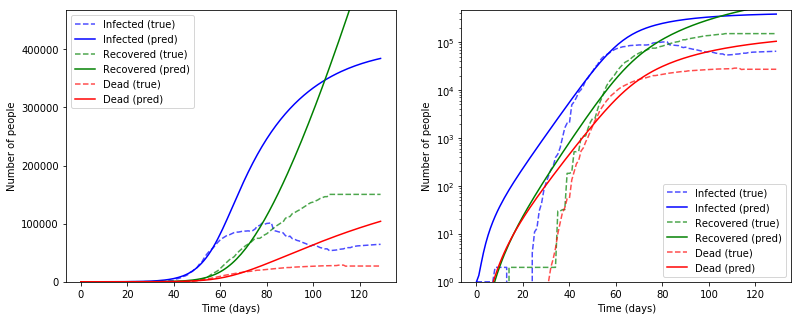

In [14]:
plot_data_together(
    time_points, solution_to_IRD(best_solution), true_ird, N/100,
    labels=["Infected", "Recovered", "Dead"],
    log_lower_bound=1
)

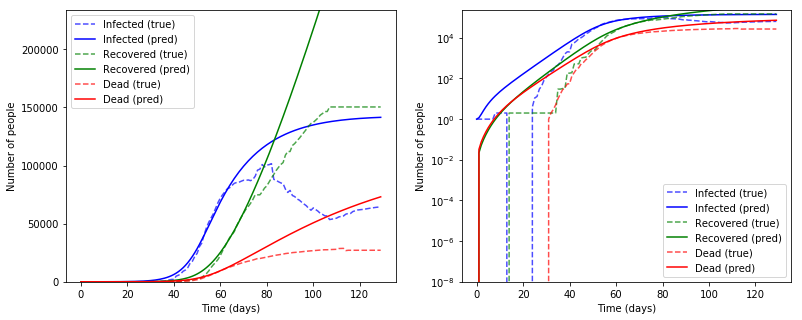

In [5]:
from scipy.integrate import odeint
fixed_best_params = np.copy(best_params)
fixed_best_params[3] = 0.6
func, init = func_getter(*fixed_best_params)
long_data = pd.read_csv('spain.csv')
long_data = long_data[10:]  # инфекции появляются только на десятый день
long_data['Заражений'] -= (long_data['Выздоровлений'] + long_data['Смертей'])
long_data = long_data[:140]
long_true_ird = (
    long_data['Заражений'],
    long_data['Выздоровлений'],
    long_data['Смертей']
)
long_time_points = np.arange(long_true_ird[0].shape[0])
long_solution = odeint(func, init, long_time_points)
plot_data_together(
    long_time_points, solution_to_IRD(long_solution), long_true_ird, N/200,
    labels=["Infected", "Recovered", "Dead"],
    log_lower_bound=1e-8
)

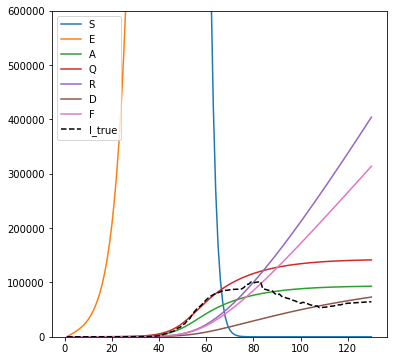

In [6]:
plt.figure(figsize=(6, 6))
func, init = func_getter(*best_params)
long_data = pd.read_csv('spain.csv')
long_data = long_data[10:]  # инфекции появляются только на десятый день
long_data['Заражений'] -= (long_data['Выздоровлений'] + long_data['Смертей'])
long_data = long_data[:140]
long_true_ird = (
    long_data['Заражений'],
    long_data['Выздоровлений'],
    long_data['Смертей']
)
long_time_points = np.arange(long_true_ird[0].shape[0])
long_solution = odeint(func, init, long_time_points)
for i, label in enumerate('SEAQRDF'):
    plt.plot(np.arange(1, 131), long_solution[:, i], label=label)
plt.plot(np.arange(1, 131), long_true_ird[0], 'k--', label='I_true')
plt.ylim([0, 6e5])
plt.legend()